## One Hot Encoding

Archaic Techniques is mostly about making a sparse matrix to represent a document with 0s and 1s.

One Hot Encoding is majourly about treating each word as a category and make a sparse vector to represent each vector.
To keep this notebook simple, we have pre-processed the wages data in the notebook "Pre-Processing of Wages Data for One-Hot Encoding". 
Pre-processing essentially included removal of features(colums) which mean the same as other column example: Education and education-num mean the same hence education is removed.

In this notebook, we will try to predict the salary of a person given his details and we will see how One-Hot Encoding impacts the accuracy.

In [8]:
#importing packages
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [9]:
#Let's see how our data looks. Our data has both categorical features as well as numerical features.
income_df = pd.read_csv("new_wages.csv")
income_df.head(5)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


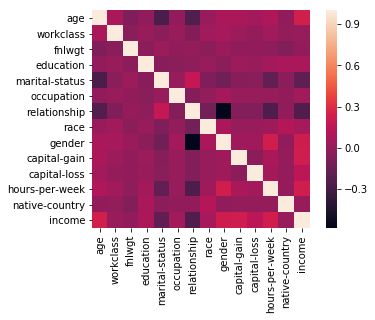

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,1,4,6,3,2,1,0,0,40,38,0
1,38,2,89814,11,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,2,10,0,4,1,0,0,40,38,1
3,44,2,160323,15,2,6,0,2,1,7688,0,40,38,1
4,34,2,198693,0,4,7,1,4,1,0,0,30,38,0


In [10]:
# For any machine learning algorithm to work we need numerical values hence we simply encode the 
# categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(income_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.head(5)

##### From the above table we can see all columns have numerical values. The problem which we can see is that for instance occupation "Machine-op-inspct(6)" has numerical value close to "Other-service(7)" than to "Farming-fishing(4)". This is really not the case as we cannot say which occupation is close to which one.

In [11]:
#Since the objective is to predict income, let's keep it in a separate column.
income_encoded = encoded_data["income"]
print(income_encoded.head(5))


0    0
1    0
2    1
3    1
4    0
Name: income, dtype: int64


In [12]:
#Let's split the rows into 70:30, where we will use 70% to train and 30% to test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("income")], income_encoded, train_size=0.70,test_size=0.30)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [13]:
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7963440701702661


##### Our prediction is has an accuracy of 0.8, but let's see which features affect the salary more using their coefficients. 

In [14]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print(coefs.sort_values(ascending = False))

capital-gain      2.456045
age               0.439644
hours-per-week    0.391527
gender            0.333875
capital-loss      0.301957
education         0.228812
race              0.095192
occupation        0.084904
fnlwgt            0.046846
native-country    0.002266
workclass        -0.092329
relationship     -0.266626
marital-status   -0.290914
dtype: float64


##### The above data shows that capital-gain affects the salary most but occupation does not affect the salary much which should not really be the case. There seems to exist a problem with the numerical encoding. So, let's try one-hot encoding...

In [16]:
# Copy the original data
features = income_df.copy()

# Select the numeric columns
numeric_subset = income_df.select_dtypes('number')
categorical_subset = income_df.select_dtypes('object')

# One hot encoding
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("income")])

# Joining the two dataframes using concat
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print (features.head())

   age  fnlwgt  capital-gain  capital-loss  hours-per-week  \
0   25  226802             0             0              40   
1   38   89814             0             0              50   
2   28  336951             0             0              40   
3   44  160323          7688             0              40   
4   34  198693             0             0              30   

   workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
0                      0                    0                  1   
1                      0                    0                  1   
2                      0                    1                  0   
3                      0                    0                  1   
4                      0                    0                  1   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                       0                           0   
1                       0                           0   
2                       0                      

In [17]:
income_encoded = encoded_data["income"]
# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, income_encoded, train_size=0.70, test_size=0.30)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [18]:
cls = linear_model.LogisticRegression()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8467605218544999


##### So, our accuracy improved  after doing one-hot encoding. Let's see if now occupation impacts the wages in significant way.

In [19]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print(coefs.sort_values(ascending = False))

capital-gain                            2.395564
marital-status_Married-civ-spouse       0.712794
hours-per-week                          0.334101
age                                     0.321845
education_Bachelors                     0.297873
capital-loss                            0.264069
education_Masters                       0.263259
occupation_Exec-managerial              0.249425
relationship_Wife                       0.234009
education_Prof-school                   0.209790
education_Doctorate                     0.176765
gender_Male                             0.156900
occupation_Prof-specialty               0.156674
relationship_Not-in-family              0.127876
fnlwgt                                  0.110156
workclass_Federal-gov                   0.108463
occupation_Tech-support                 0.093923
native-country_United-States            0.079244
occupation_Sales                        0.077380
occupation_Protective-serv              0.070703
race_Asian-Pac-Islan

##### The goal of this notebook is not to improve the accuracy but to show how one-hot encoding is better than straight numerical encoding.